In [2]:
import networkx as nx
from torch_geometric.data import Data
import torch

from sentence_transformers import SentenceTransformer

import json
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.metrics import f1_score

/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_to_training = Path("training")
path_to_test = Path("test")

# Recup des ids des diaoganls
transcription_ids = []
transcripts = path_to_training.glob('*.json')
for transcript in transcripts:
    transcription_ids.append(transcript.name[:-5])

In [4]:
# les labels du training
with open("training_labels.json", 'r') as f:
    transcription_labels = json.load(f)

In [5]:
bert = SentenceTransformer('distilbert-base-uncased')

No sentence-transformers model found with name /Users/dabereabasse/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.


## Définir les arêtes et les types d'arêtes

In [6]:
def get_edge_list(transcription_id, path_to_data):
    discourse_graph = [] # list, i attribute j
    with open(path_to_data / f"{transcription_id}.txt", 'r') as f:
        for line in f:
            tmp = line.split()
            discourse_graph.append((int(tmp[0]), int(tmp[2]), tmp[1]))
    return discourse_graph

def get_replique(transcription_id, path_to_data):
    with open(path_to_data / f"{transcription_id}.json", 'r') as f:
        transcription = json.load(f)
    ret = []
    for i in range(len(transcription)):
        text = transcription[i]['text']
        ret.append(text)
    return ret

def create_data_object(transcription_id, labels=None, path_to_data = path_to_training):
    edge_list = get_edge_list(transcription_id, path_to_data)
    # Créer un graphe NetworkX
    G = nx.DiGraph()
    for src, dest, edge_type in edge_list:
        G.add_edge(src, dest, relation=edge_type)

    # Encoder les types d'arêtes
    edge_types = list(set([edge[2] for edge in edge_list]))
    edge_type_index = {edge_type: i for i, edge_type in enumerate(edge_types)}

    # Préparer les données pour PyTorch Geometric
    edges = []
    edge_attrs = []
    for src, dest, edge_type in G.edges(data='relation'):
        edges.append((src, dest))
        edge_attrs.append(edge_type_index[edge_type])

    # Conversion en Tenseurs PyTorch
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    x = torch.tensor(bert.encode(get_replique(transcription_id, path_to_data), show_progress_bar=True))
    y = torch.tensor(labels) if labels else None
    data = Data(edge_index=edge_index, edge_attr=edge_attr, x = x, y=y)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[:int(0.8*data.num_nodes)] = True

    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[int(0.8*data.num_nodes):] = True

    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    # Créer un objet Data pour PyTorch Geometric
    return data

In [7]:
# Créer un Data object pour chaque dialogue
graphs_data = [create_data_object(dialogue, transcription_labels[dialogue]) for dialogue in transcription_ids]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches: 100%|██████████| 18/18 [00:01<00:00,  9.67it/s]


In [205]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0,1], y= list(transcription_labels.values())[0])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [9]:
class_weights = torch.tensor([1, 1], dtype=torch.float)

## Modèle GCN

In [10]:
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import GCNConv, global_add_pool, global_mean_pool, SAGPooling
from torch.nn import Linear, BatchNorm1d
import torch.nn.functional as F

In [223]:
arch = [400, 200, 100]
p = [0.16496388, 0.49430627, 0.37350436]
trashold = 0.6696969696969697

class GCNModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, 512)

        self.fc1 = Linear(512, 200)
        self.fc2 = Linear(200, 100)

        self.fc3 = Linear(100, 32)

        self.classifier = Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.classifier(x)
        ans = F.log_softmax(x, dim=1)
        print(ans)
        return ans

## Entraînement du Modèle

In [224]:
NUM_FEATURES = graphs_data[0].x.shape[1]
NUM_CLASSES = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(10):
    total_loss = 0
    for data in graphs_data:  # Remplacez par vos données d'entraînement
        data = data.to(device)
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}, Loss: {total_loss / len(graphs_data)}')

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

RuntimeError: weight tensor should be defined either for all 1 classes or no classes but got weight tensor of shape: [2]

## Évaluer le Modèle

In [207]:
model.eval()
all_preds = []
all_labels = []

for data in graphs_data:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    pred = pred[data.test_mask].cpu().numpy()
    true_labels = data.y[data.test_mask].cpu().numpy()
    all_preds.extend(pred)
    all_labels.extend(true_labels)

In [208]:
f1 = f1_score(all_labels, all_preds)
print(f"F1-Score: {f1}")

F1-Score: 0.3625980060013552


In [209]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

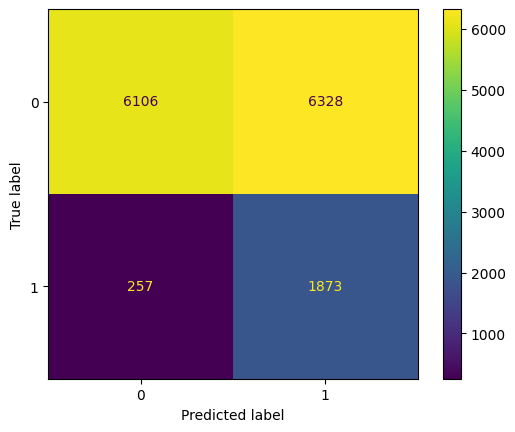

In [210]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

### Architecture Random

In [192]:
class GCNModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, arch):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, arch[0])

        self.fc1 = Linear(arch[0], arch[1])
        self.fc2 = Linear(arch[1], arch[2])

        self.classifier = Linear(arch[2], num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

architectures = [[400, 200, 16], [400, 200, 32], [500, 200, 16], [500, 200, 32], [600, 200, 16], [600, 200, 32]]

best_f1 = 0
best_arch = None

for arch in architectures:
    print(f"Architecture: {arch}")
    model = GCNModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES, arch=arch).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(10):
        total_loss = 0
        for data in graphs_data:  # Remplacez par vos données d'entraînement
            data = data.to(device)
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch}, Loss: {total_loss / len(graphs_data)}')


    model.eval()
    all_preds = []
    all_labels = []

    for data in graphs_data:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        pred = pred[data.test_mask]
        true_labels = data.y[data.test_mask]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds)
    if f1 > best_f1:
        best_f1 = f1
        best_arch = arch

Architecture: [400, 200, 16]
Epoch 0, Loss: 0.6176791949984953
Epoch 1, Loss: 0.5415282986827732
Epoch 2, Loss: 0.5336586734683243
Epoch 3, Loss: 0.5355373077171365
Epoch 4, Loss: 0.5349282668423407
Epoch 5, Loss: 0.538160602763756
Epoch 6, Loss: 0.5289279612683758
Epoch 7, Loss: 0.535454624092456
Epoch 8, Loss: 0.5304220610672665
Epoch 9, Loss: 0.5299766963904666
Architecture: [400, 200, 32]
Epoch 0, Loss: 0.6038210287536543
Epoch 1, Loss: 0.5451834552066842
Epoch 2, Loss: 0.5360191458279324
Epoch 3, Loss: 0.5392557662172416
Epoch 4, Loss: 0.534663853571587
Epoch 5, Loss: 0.531411486188161
Epoch 6, Loss: 0.5323531793564865
Epoch 7, Loss: 0.5356707364013514
Epoch 8, Loss: 0.5302860119293645
Epoch 9, Loss: 0.5361622657972512
Architecture: [500, 200, 16]
Epoch 0, Loss: 0.5989350068200495
Epoch 1, Loss: 0.5480544385836297
Epoch 2, Loss: 0.5424567430289751
Epoch 3, Loss: 0.5363637860288325
Epoch 4, Loss: 0.5356828591872737
Epoch 5, Loss: 0.536745577743373
Epoch 6, Loss: 0.5399520778164422


In [195]:
best_f1

0.38186932064041545

## Nouvelles Données Test

In [194]:
# Recup des ids
test_transcript_ids = []

test_transcripts = path_to_test.glob('*.json')
for test_transcript in test_transcripts:
    test_transcript_ids.append(test_transcript.name[:-5])

In [26]:
test_data = [create_data_object(dialogue, path_to_data =path_to_test) for dialogue in test_transcript_ids]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Batches: 100%|██████████| 46/46 [00:03<00:00, 11.90it/s]


In [27]:
test_labels_gcn = {}
for i in range(len(test_transcript_ids)):
    transcription_id = test_transcript_ids[i]
    data = test_data[i]
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    pred = pred.cpu().numpy()
    test_labels_gcn[transcription_id] = pred.tolist()

In [28]:
uniques = set()
for keys in test_labels_gcn.keys():
    uniques.update(test_labels_gcn[keys])

In [29]:
uniques

{0}

In [ ]:
class GCNModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print(x.shape)  # Doit être de la forme [num_nodes, num_features]
        #print(edge_index.shape)  # Doit être de la forme [2, num_edges]
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = global_max_pool(x, data.batch, size=data.num_nodes)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)